# GenAI with Python: Agents from scratch

###### [Article: TowardsDataScience]()

### 0 - Setup

In [1]:
#pip install langchain --> 0.2.14
#pip install langgraph --> 0.2.19
#pip install ollama --> 0.3.1

In [2]:
import ollama

llm = "llama3.1"
q = '''who died on September 9, 2024?'''

res = ollama.chat(model=llm, 
                  messages=[{"role":"system", "content":""},
                            {"role":"user", "content":q}])
res

{'model': 'llama3.1',
 'created_at': '2024-09-20T10:56:47.065168Z',
 'message': {'role': 'assistant',
  'content': "I can't predict the future or provide information about people who have not yet passed away. However, I can suggest some ways you might be able to find information about notable deaths that occurred in your specified timeframe.\n\nTo find information about deaths, try checking reputable news sources like BBC News, CNN, Al Jazeera, The New York Times, or local newspapers in the areas relevant to your search. You could also look into online obituary platforms and public databases such as Legacy.com, which aggregates death notices from various sources around the world.\n\nKeep in mind that information about deaths becomes available after they occur. Therefore, you will not be able to find accurate information about deaths until September 10th, 2024."},
 'done_reason': 'stop',
 'done': True,
 'total_duration': 37671301007,
 'load_duration': 7421343079,
 'prompt_eval_count': 2

### 1 - Tools

In [3]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

@tool("tool_browser")
def tool_browser(q:str) -> str:
    """Search on DuckDuckGo browser"""
    return DuckDuckGoSearchRun().run(q)

print( tool_browser(q) )

/var/folders/_z/cl6cx94516g2tlbhzcbl4nfc0000gn/T/ipykernel_1882/2076258990.py:9: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use invoke instead.
  print( tool_browser(q) )


Famous deaths in September 2024. Learn about 17 historical figures, notable people and celebrities who died in Sep 2024 like James Earl Jones and Alberto Fujimori. Rochester, Indiana. September 9, 2024 (79 years old) Vickey Karen Bryant. Atkins, Arkansas. September 9, 2024 (72 years old) Kathleen A. Jenkins. Yonkers, New York. September 9, 2024 (73 years old) Tommy Collins Jr. Actor James Earl Jones, known for his booming voice and many memorable performances, died Monday morning, according to his agent Barry McPherson. ... Mon September 9, 2024 Link Copied! FILE - James Earl Jones arrives before the 84th Academy Awards on Sunday, Feb. 26, 2012, in the Hollywood section of Los Angeles. Jones, who overcame racial prejudice and a severe stutter to become a celebrated icon of stage and screen has died at age 93. His agent, Barry McPherson, confirmed Jones died Monday morning, Sept. 9, 2024, at home. Frankie Beverly. Prince Williams/WireImage. Frankie Beverly, the soul and R&B legend who f

In [4]:
@tool("final_answer")
def final_answer(text:str) -> str:
    """Returns a natural language response to the user. 
    You should provide as much context as possible and specify the source of the information.
    """
    return text

print( final_answer("yo") )

yo


In [5]:
dic_tools = {"tool_browser":tool_browser, 
             "final_answer":final_answer}

### 2 - Decision Making

In [6]:
prompt = """
You know everything, you must answer every question from the user, you can use the list of tools provided to you.
Your goal is to provide the user with the best possible answer, including key information about the sources and tools used.

Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
Remember, do NOT use any tool with the same query more than once.
Remember, if the user doesn't ask a specific question, you MUST use the `final_answer` tool directly.

Every time the user asks a question, you take note of some keywords in the memory.
Every time you find some information related to the user's question, you take note of some keywords in the memory.

You should aim to collect information from a diverse range of sources before providing the answer to the user. 
Once you have collected plenty of information to answer the user's question use the `final_answer` tool.
"""

In [7]:
str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])

prompt_tools = f"You can use the following tools:\n{str_tools}"
print(prompt_tools)

You can use the following tools:
1. `tool_browser`: Search on DuckDuckGo browser
2. `final_answer`: Returns a natural language response to the user. 
    You should provide as much context as possible and specify the source of the information.


In [9]:
# LLM deciding what tool to use
from pprint import pprint

llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":"hello"}
             ], format="json")

pprint(llm_res)

{'created_at': '2024-09-20T10:57:33.954938Z',
 'done': True,
 'done_reason': 'stop',
 'eval_count': 24,
 'eval_duration': 3835831000,
 'load_duration': 26255423,
 'message': {'content': '{"name":"final_answer", "parameters": '
                        '{"message":"Hello! I\'m happy to chat with you."}}',
             'role': 'assistant'},
 'model': 'llama3.1',
 'prompt_eval_count': 309,
 'prompt_eval_duration': 218874000,
 'total_duration': 4084199400}


In [10]:
# LLM deciding what tool to use (output format = json)
llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":q}
             ], format="json")

llm_res["message"]["content"]

'{"name":"tool_browser", "parameters": {"q":"September 9 2024 death news"}}'

In [11]:
import json

input = json.loads(llm_res["message"]["content"])["parameters"]["q"]
input

'September 9 2024 death news'

In [12]:
# LLM with context
context = tool_browser(input)
print("tool output:\n", context)

llm_output = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":"Give the most accurate answer using the folling information:\n"+context},
              {"role":"user", "content":q}
             ])

print("\nllm output:\n", llm_output["message"]["content"])

tool output:
 FILE - James Earl Jones arrives before the 84th Academy Awards on Sunday, Feb. 26, 2012, in the Hollywood section of Los Angeles. Jones, who overcame racial prejudice and a severe stutter to become a celebrated icon of stage and screen has died at age 93. His agent, Barry McPherson, confirmed Jones died Monday morning, Sept. 9, 2024, at home. James Earl Jones sits for a portrait in September 2014. Jesse Dittmar for The Washington Post/Getty Images Jones, seen here in 1960, was born in Arkabutla, Mississippi, in 1931. September 9, 2024 1:33pm. James Earl Jones in 2015 WireImage. James Earl Jones, the revered actor who voiced Star Wars villain Darth Vader, starred in Field of Dreams and many other films and ... Sep 1 John Schultz, Australian Football HOF ruckman (Brownlow Medal 1960; All Australian 1961; Victoria 24 games; Footscray FC), dies at 85. Sep 2 Aleksandr Medved, Ukrainian freestyle wrestler (Olympic gold USSR heavyweight 1964, 68, 72; World C'ship gold x 7), dies

### 3 - Agent

##### Data Structure

In [13]:
from pydantic import BaseModel #this is the standard class

# Taking for example the last LLM response, I want this structure:
# {tool_name: 'tool_browser', 
#  tool_input: {'q':'September 9 2024 deaths'}, 
#  tool_output: str( tool_browser({'q':'September 9 2024 deaths'})) }

class AgentRes(BaseModel):
    tool_name: str  #<--must be a string = 'tool_browser'
    tool_input: dict #<--must be a dictionary = {'q':'September 9 2024 deaths'}
    tool_output: str | None = None #can be a string or None, default = None
    
    @classmethod
    def from_llm(cls, res:dict): #<--return the class itself
        try:
            out = json.loads(res["message"]["content"])
            return cls(tool_name=out["name"], tool_input=out["parameters"])
        except Exception as e:
            print(f"Error from Ollama:\n{res}\n")
            raise e

# test
agent_res = AgentRes.from_llm(llm_res)
print("from\n", llm_res["message"]["content"], "\nto")
agent_res

from
 {"name":"tool_browser", "parameters": {"q":"September 9 2024 death news"}} 
to


AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 death news'}, tool_output=None)

In [14]:
# test the tool output
AgentRes(tool_name="tool_browser", 
         tool_input={'q':'September 9 2024 deaths'}, 
         tool_output=str( tool_browser({'q':'September 9 2024 deaths'})) )

AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Famous deaths in September 2024. Learn about 17 historical figures, notable people and celebrities who died in Sep 2024 like James Earl Jones and Alberto Fujimori. Menu. ... James Earl Jones (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... 1926 William S. Scarborough, American linguist and author (Birds of Aristophanes), dies at 74. 1931 Lujo Brentano, German economist and social reformer, dies at 86. 1934 Roger Fry, English artist and art critic, dies at 67. 1941 Gustav Ehrismann, German author and expert on the German language, dies at 85. Updated on September 19, 2024 01:06AM EDT. After saying sad and shocking goodbyes to the many stars who died in 2023, ... died at Aug. 9 at age 74. A cause of death was not immediately released ... Overall, state media reported 21 deaths and at lea

##### Memory System

In [16]:
'''
Messages in Memory will have this structure:
[{'role':'assistant', 'content':'{"name":"final_answer", "parameters":{"text":"How can I assist you today?"}}'},
 {'role':'user', 'content':None}]
'''

def save_memory(lst_res:list[AgentRes], user_q:str) -> list:
    ## create
    memory = []
    for res in [res for res in lst_res if res.tool_output is not None]:
        memory.extend([
            ### assistant message
            {"role": "assistant", "content": json.dumps({"name":res.tool_name, "parameters":res.tool_input})},
            ### user message
            {"role":"user", "content":res.tool_output}
        ])
    
    ## add a reminder of the original goal
    if memory:
        memory += [{"role":"user", "content":(f'''
                This is just a reminder that my original query was `{user_q}`.
                Only answer to the original query, and nothing else, but use the information I gave you. 
                Provide as much information as possible when you use the `final_answer` tool.
                ''')}]
    return memory

save_memory(lst_res=[agent_res], user_q=q)

[]

In [17]:
chat_history = [{"role": "user", "content": "hi there, how are you?"},
                {"role": "assistant", "content": "I'm good, thanks!"},
                {"role": "user", "content": "I have a question"},
                {"role": "assistant", "content": "tell me"}]

##### Run the Agent

In [21]:
def run_agent(user_q:str, chat_history:list[dict], lst_res:list[AgentRes], lst_tools:list) -> AgentRes:
    ## start memory
    memory = save_memory(lst_res=lst_res, user_q=user_q)
    
    ## track used tools
    if memory:
        tools_used = [res.tool_name for res in lst_res]
        if len(tools_used) >= len(lst_tools):
            memory[-1]["content"] = "You must now use the `final_answer` tool."
        
    ## messages
    messages = [{"role":"system", "content":prompt+"\n"+prompt_tools},
                *chat_history,
                {"role":"user", "content":user_q},
                *memory]
    pprint(messages)
    
    ## output
    llm_res = ollama.chat(model=llm, messages=messages, format="json")
    return AgentRes.from_llm(llm_res)

# test
agent_res = run_agent(user_q=q, chat_history=chat_history, lst_res=[], lst_tools=dic_tools.keys())
print("\nagent_res:", agent_res)

[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directly.\n'
             

### 4 - Graph Workflow

##### State

In [22]:
import typing

class State(typing.TypedDict):
    user_q: str
    chat_history: list 
    lst_res: list[AgentRes]
    output: dict

# test
state = State({"user_q":q, "chat_history":chat_history, "lst_res":[agent_res], "output":{}})
state

{'user_q': 'who died on September 9, 2024?',
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'},
  {'role': 'assistant', 'content': "I'm good, thanks!"},
  {'role': 'user', 'content': 'I have a question'},
  {'role': 'assistant', 'content': 'tell me'}],
 'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 death'}, tool_output=None)],
 'output': {}}

##### Nodes

In [24]:
# Agent
def node_agent(state):
    print("--- node_agent ---")
    agent_res = run_agent(user_q=state["user_q"], 
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"],
                          lst_tools=dic_tools.keys())
    return {"lst_res":[agent_res]} #<--must return a the list of agent_res

# test
node_agent(state)

--- node_agent ---
[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directl

{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 death'}, tool_output=None)]}

In [25]:
# Tools
def node_tool(state):
    print("--- node_tool ---")
    res = state["lst_res"][-1]
    print(f"run_tool --> {res.tool_name}(input={res.tool_input})")
    
    agent_res = AgentRes(tool_name=res.tool_name, 
                         tool_input=res.tool_input, 
                         tool_output=str(dic_tools[res.tool_name](res.tool_input)) )
    
    return {"output":agent_res} if res.tool_name == "final_answer" else {"lst_res":[agent_res]}

# test
node_tool(state)

--- node_tool ---
run_tool --> tool_browser(input={'q': 'September 9 2024 death'})


{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 death'}, tool_output='September 9, 2024 (80 years old) Andrew Wayne Volkers. Sweet Home, Oregon. September 9, 2024 (43 years old) Donald D. Isgrigg. Rushville, Indiana. September 9, 2024 (71 years old) Lenore Jane Bartley. Rocky Hill, Connecticut. Actor James Earl Jones, known for his booming voice and many memorable performances, died Monday morning, according to his agent Barry McPherson. ... Mon September 9, 2024 Link Copied! Famous deaths in September 2024. Learn about 17 historical figures, notable people and celebrities who died in Sep 2024 like James Earl Jones and Alberto Fujimori. Frankie Beverly. Prince Williams/WireImage. Frankie Beverly, the soul and R&B legend who founded the funk band Maze, has died at 77. His family announced the news in a Sep. 11 Instagram post ... FILE - James Earl Jones arrives before the 84th Academy Awards on Sunday, Feb. 26, 2012, in the Hollywood section of Los Ange

##### Edges

In [26]:
def edges(state):
    print("--- edges ---")
    return state["lst_res"][-1].tool_name if isinstance(state["lst_res"], list) else "final_answer"

edges(state)

--- edges ---


'tool_browser'

##### Graph

In [27]:
from langgraph.graph import StateGraph, END

## start the graph
workflow = StateGraph(State)

## add Agent node
workflow.add_node(node="Agent", action=node_agent) 
workflow.set_entry_point(key="Agent")  #<--user query

## add Tools nodes
for k in dic_tools.keys():
    workflow.add_node(node=k, action=node_tool)

## edges from Agent
workflow.add_conditional_edges(source="Agent", path=edges)

## edges to Agent
for k in dic_tools.keys():
    if k != "final_answer":
        workflow.add_edge(start_key=k, end_key="Agent")

## end the graph
workflow.add_edge(start_key="final_answer", end_key=END)
g = workflow.compile()

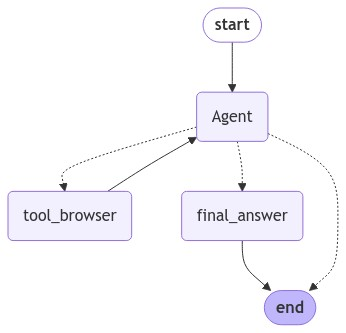

In [28]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(
    g.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

##### Run

In [29]:
out = g.invoke(input={'user_q':q,
                      'chat_history':chat_history, 
                      'lst_res':[], 
                      'output':{}
                     })

--- node_agent ---
[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directl

In [30]:
## Give the first input state
steps = g.stream(input={'user_q':q,
                        'chat_history':chat_history, 
                        'lst_res':[], 
                        'output':{}
                       }) 
for step in steps:
    print(step)
    print("----")

--- node_agent ---
[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directl